## Image Classifier

Problem : Classification of Flowers

Dataset Used : http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html

Model Used : VGG16

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from collections import OrderedDict

import json
from PIL import Image

# Dataset

The dataset should be split into three parts, training, validation, and testing.

For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

# Assigning the Directories

In [10]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [11]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30), transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(), transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validataion_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], 
                                                                  [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])]) 

# TODO: Load the datasets with ImageFolder
image_datasets = [datasets.ImageFolder(train_dir, transform=train_transforms),
                  datasets.ImageFolder(valid_dir, transform=validataion_transforms),
                  datasets.ImageFolder(test_dir, transform=test_transforms)]

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = [torch.utils.data.DataLoader(image_datasets[0], batch_size=64, shuffle=True),
               torch.utils.data.DataLoader(image_datasets[1], batch_size=64, shuffle=True),
               torch.utils.data.DataLoader(image_datasets[2], batch_size=64, shuffle=True)]


# Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [12]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

It's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.



In [13]:
# TODO: Build and train your network

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Load the pre-trained network VGG16
model = models.vgg19(pretrained = True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout

In [14]:


# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Define the new classifier for the model

classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 4096)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.2)),
    ('fc2', nn.Linear(4096, 512)),
    ('relu', nn.ReLU()),   
    ('fc3', nn.Linear(512, 256)), 
    ('relu', nn.ReLU()),    
    ('fc4', nn.Linear(256, 102)),
    ('output', nn.LogSoftmax(dim=1))
    ]))

# Update the classifier in the model
model.classifier = classifier

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [15]:
# Move the model to Cuda
model = model.to('cuda')

#Define the learning rate
learning_rate = 0.001

# Define the loss
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

Train the classifier layers using backpropagation using the pre-trained network to get the features

Track the loss and accuracy on the validation set to determine the best hyperparameters

In [16]:


epochs = 7
print_every = 10
steps = 0
    

for e in range(epochs):
    running_loss = 0
    for ii, (inputs, labels) in enumerate(dataloaders[0]): 
        steps += 1
        
        # Move input and label tensors to the default device (use cuda)
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        # Zeros the gradients on each training pass
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        # Use the logits to calculate the loss
        loss = criterion(outputs, labels)
        # Perform a backward pass through the network to calculate the gradients
        loss.backward()
        # Take a step with the optimizer to update the weights
        optimizer.step()
        
        # Calculate the training loss
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            valloss = 0
            accuracy=0
        
            for ii, (inputs2,labels2) in enumerate(dataloaders[1]):
                    optimizer.zero_grad()

                    inputs2, labels2 = inputs2.to('cuda') , labels2.to('cuda') # use cuda
                    model.to('cuda:0') 
                    with torch.no_grad():    
                        outputs = model.forward(inputs2)
                        valloss = criterion(outputs,labels2)
                        ps = torch.exp(outputs).data
                        equality = (labels2.data == ps.max(1)[1])
                        accuracy += equality.type_as(torch.FloatTensor()).mean()

            valloss = valloss / len(dataloaders[1])
            accuracy = accuracy /len(dataloaders[1])

            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Train Loss: {:.4f}".format(running_loss/print_every),
                  "Validation Loss: {:.4f}".format(valloss),
                  "Test accuracy: {:.4f}".format(accuracy),
                 )

            running_loss = 0


Epoch: 1/7...  Train Loss: 5.7125 Validation Loss: 0.3216 Test accuracy: 0.0961
Epoch: 1/7...  Train Loss: 3.9341 Validation Loss: 0.2659 Test accuracy: 0.2140
Epoch: 1/7...  Train Loss: 3.2716 Validation Loss: 0.2402 Test accuracy: 0.3091
Epoch: 1/7...  Train Loss: 3.0083 Validation Loss: 0.1898 Test accuracy: 0.4269
Epoch: 1/7...  Train Loss: 2.5410 Validation Loss: 0.1543 Test accuracy: 0.4629
Epoch: 1/7...  Train Loss: 2.1926 Validation Loss: 0.1391 Test accuracy: 0.5100
Epoch: 1/7...  Train Loss: 2.1660 Validation Loss: 0.1410 Test accuracy: 0.5230
Epoch: 1/7...  Train Loss: 1.8667 Validation Loss: 0.0849 Test accuracy: 0.6326
Epoch: 1/7...  Train Loss: 1.7364 Validation Loss: 0.0669 Test accuracy: 0.6485
Epoch: 1/7...  Train Loss: 1.5701 Validation Loss: 0.0890 Test accuracy: 0.6565
Epoch: 2/7...  Train Loss: 1.0912 Validation Loss: 0.1055 Test accuracy: 0.6748
Epoch: 2/7...  Train Loss: 1.4688 Validation Loss: 0.0935 Test accuracy: 0.6995
Epoch: 2/7...  Train Loss: 1.4000 Valida

## Testing our network
Here we will be testing our model and calculaing some hyper parameters like accuracy.

In [17]:
# TODO: Do validation on the test set
correct = 0
total = 0
model.to('cuda')
with torch.no_grad():
    for data in dataloaders[2]:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test images accuracy : %d %%' % (100 * correct / total))


Test images accuracy : 78 %


## Saving ur Model for Further Use


In [18]:
# TODO: Save the checkpoint 
model.class_to_idx = image_datasets[0].class_to_idx

checkpoint = {'input_size': 25088,
              'output_size': 102,
              'arch': 'vgg19',
              'classifier' : classifier,
              'learning_rate': learning_rate,
              'batch_size': 64,
              'epochs': epochs,
              'class_to_idx': model.class_to_idx,
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(),
             }

#Saving it to a file
torch.save(checkpoint, 'trained_model.pth')

## Function to Load the checkpoint


In [19]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(pathname):
    checkpoint = torch.load(pathname)
    arch = checkpoint['arch']
    model = getattr(torchvision.models, checkpoint['arch'])(pretrained=True)
    model.classifier = checkpoint['classifier']
    learning_rate = checkpoint['learning_rate']
    model.epochs = checkpoint['epochs']
    model.optimizer = checkpoint['optimizer']
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    
    return model


### Loading our Saved Model

In [20]:
#Load the model
model = load_checkpoint('checkpoint.pth')  

# Function to use our Model

This function takes in model and image as parameters.
It returns the Top K classes for the Image.

### Function to Preprocess the Input Image

In [21]:
def process_image(image):
    
    # TODO: Process a PIL image for use in a PyTorch model
    image = Image.open(image)

    if image.size[0] > image.size[1]:
        size = [image.size[0], 256]
    else:
        size = [256, image.size[1]]
    
    # Resize the image and use ANTIALIAS to reduce the distortion
    image.thumbnail(size, Image.ANTIALIAS)
    
    # Crop the image to 224 x 224 by adjusting the cartesian coordinates needed for the crop function
    left = (256 - 224)/2
    upper = (256 - 224)/2
    right = (256 + 224)/2
    lower = (256 + 224)/2

    image = image.crop((left, upper, right, lower))
    
    # Adjust the color channel values (0-255) to floats between 0 and 1
    image = np.array(image)
    image = image/255.
    
    # Normalize the image as was done in the model above
    mean = np.array([0.485, 0.456, 0.406])
    sd = np.array([0.229, 0.224, 0.225])
                       
    image = ((image - mean) / sd)
    
    image = np.transpose(image, (2, 0, 1))
    
    return image

Function to show whether the Original Image and the Cropped Image

<AxesSubplot:>

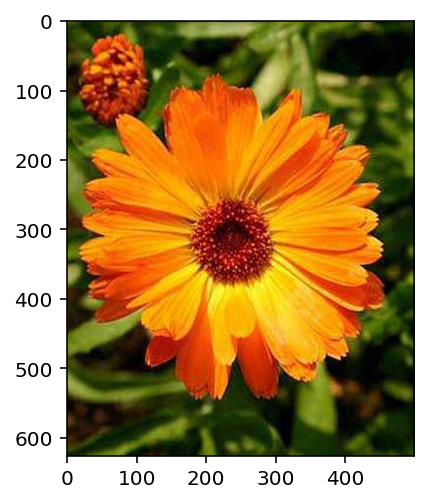

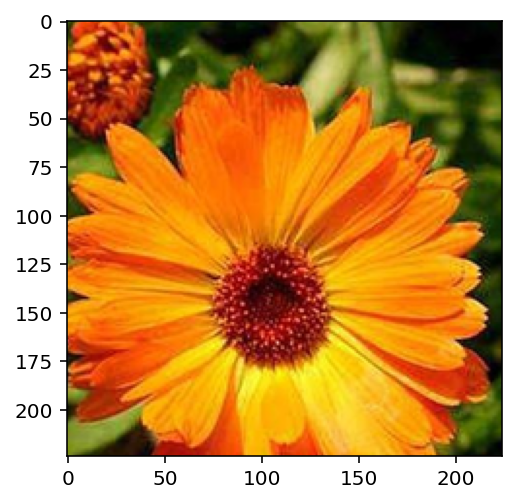

In [22]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

#Display the original and modified image
image_pth = 'flowers\\test\\5\\image_05159.jpg'

# original
with Image.open(image_pth) as image: 
    plt.imshow(image)
    
#processed image    
imshow(process_image(image_pth)) 

## Class Prediction



In [23]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    model.to('cuda')
    model.eval()
    
    image = process_image(image_path)
    image = torch.from_numpy(np.array([image]))
    image = image.float()
    
    with torch.no_grad():
        output = model.forward(image.cuda())
        
    # Calculate the probabilities
    ps = F.softmax(output.data, dim =1)
   
    
    # Get the top five probabilities
    top_ps, top_classes = ps.topk(topk, dim=1)       
    top_p = top_ps.tolist()[0]
    
    # Displays the numeric category
    #index_to_class = {val:key for key, val in model.class_to_idx.items()}   
    
    # Displays the category name
    index_to_class = {val:cat_to_name[k] for k, val in model.class_to_idx.items()}  

    top_class = [index_to_class[i] for i in top_classes.tolist()[0]]
    #top_class = [index_to_class[i] for i in np.array(ps.topk(topk)[1][0])]

    return top_p, top_class

In [24]:
# Implement the predict function on an image
image_path = "flowers\\valid\\9\\image_06398.jpg" # should be pink primrose

probs, classes = predict(image_path, model)

print(probs)
print(classes)

[0.469762921333313, 0.2665092647075653, 0.10108838975429535, 0.09849226474761963, 0.0361035130918026]
['pelargonium', 'balloon flower', 'clematis', 'monkshood', 'canterbury bells']


## Sanity Checking

Sometimes though the Testing Accuracy is High , we need to make sure that we don't have any Bugs/errors.

To ensure the same we will plo a graph to check the top 5 classes of the given image with their respective probabilities.

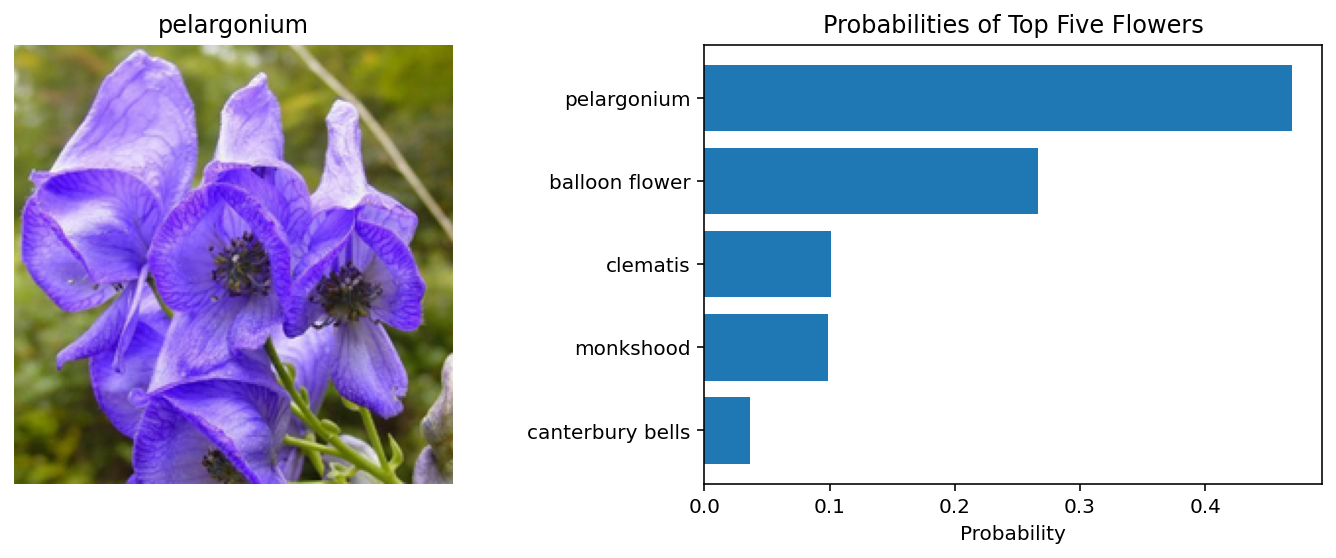

In [26]:
image_pth = "flowers\\valid\\9\\image_06398.jpg"
image = process_image(image_pth)

# Run the image through the predict function to get the top 5 choices
top_p, top_c = predict(image_pth, model)
top_class = top_c[0]

# Set the plot area to display two plots
fig, (ax1, ax2) = plt.subplots(figsize=(10,4), ncols=2)

# Display the processed image for the first plot
ax1.axis('off')
ax1.set_title(top_class)
imshow(image, ax = ax1)

# Display a bar chart (Probabilities of top five flower's) 
ax2.set_xlabel('Probability')
ax2.set_title('Probabilities of Top Five Flowers')
ax2.set_yticks(np.arange(5))
ax2.set_yticklabels(top_c)

#highest probabilities on top
ax2.invert_yaxis()

ax2.barh(np.arange(5), top_p)
fig.tight_layout()

plt.show()